# Section 1: Data Loading & Initial Review

Load and inspect the experimental dataset to confirm structure, variables, and readiness for analysis.

In [1]:
import pandas as pd
from scipy import stats

# Load the dataset
df = pd.read_csv('Sales_without_NaNs_v1.3.csv')

# Display basic info and first few rows
print("Data Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Group                         10000 non-null  object 
 1   Customer_Segment              10000 non-null  object 
 2   Sales_Before                  10000 non-null  float64
 3   Sales_After                   10000 non-null  float64
 4   Customer_Satisfaction_Before  10000 non-null  float64
 5   Customer_Satisfaction_After   10000 non-null  float64
 6   Purchase_Made                 10000 non-null  object 
dtypes: float64(4), object(3)
memory usage: 547.0+ KB
None

First 5 rows:
       Group Customer_Segment  Sales_Before  Sales_After  \
0    Control       High Value    240.548359   300.007568   
1  Treatment       High Value    246.862114   381.337555   
2    Control       High Value    156.978084   179.330464   
3    Control     Medium Value    192.

The dataset is clean, well-structured, and suitable for controlled experimentation, providing a reliable foundation for causal analysis.

# Section 2: Experiment Validity & Statistical Readiness Checks

Validate randomisation quality, pre-experiment balance, and statistical power before evaluating treatment effects.

In [2]:
from statsmodels.stats.power import TTestIndPower

# Sanity Check 1: Sample Ratio Mismatch (SRM) Check
# Check if the number of samples in Control and Treatment are balanced
group_counts = df['Group'].value_counts()
print("\nGroup Counts:")
print(group_counts)


Group Counts:
Group
Control      5013
Treatment    4987
Name: count, dtype: int64


In [3]:
# Sanity Check 2: Pre-experiment Bias Check
# Compare the means of 'Sales_Before' and 'Customer_Satisfaction_Before'
pre_experiment_means = df.groupby('Group')[['Sales_Before', 'Customer_Satisfaction_Before']].mean()
pre_experiment_means = pre_experiment_means.T
pre_experiment_means['Difference'] = pre_experiment_means['Control'] - pre_experiment_means['Treatment']
print("\nPre-experiment Means:")
print(pre_experiment_means)

# Perform T-test on Sales_Before to statistically confirm if they are different
control_sales_before = df[df['Group'] == 'Control']['Sales_Before']
treatment_sales_before = df[df['Group'] == 'Treatment']['Sales_Before']

t_stat, p_val = stats.ttest_ind(control_sales_before, treatment_sales_before)
print(f"\nT-test results for Sales_Before (Control vs Treatment):")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_val:.4f}")


Pre-experiment Means:
Group                            Control   Treatment  Difference
Sales_Before                  203.025125  204.671596   -1.646471
Customer_Satisfaction_Before   70.481815   70.015023    0.466792

T-test results for Sales_Before (Control vs Treatment):
T-statistic: -1.4852, P-value: 0.1375


In [4]:
# Sanity Check 3: Power Analysis Check
# Parameters
n_control = group_counts['Control']
n_treatment = group_counts['Treatment']
# Use the smaller n for conservative estimate, or average.
n_samples = min(n_control, n_treatment)
alpha = 0.05
power = 0.80

# Initialize Power Analysis object
analysis = TTestIndPower()

# Calculate Minimum Detectable Effect (MDE) - Cohen's d
# We solve for effect_size
mde = analysis.solve_power(effect_size=None, 
                           nobs1=n_samples, 
                           alpha=alpha, 
                           power=power, 
                           ratio=1.0) # Assuming equal sample sizes roughly

print(f"\nMinimum Detectable Effect (Cohen's d): {mde:.4f}")

# Translate Cohen's d back to real Sales dollars to make it intuitive
# We need the standard deviation of Sales_Before to interpret 'd'
std_sales_before = df['Sales_Before'].std()
mde_in_dollars = mde * std_sales_before

print(f"Standard Deviation of Sales_Before: ${std_sales_before:.2f}")
print(f"Minimum Detectable Difference in Sales: ${mde_in_dollars:.2f}")

# Also check power for a small effect size (d=0.05, very small)
power_small = analysis.solve_power(effect_size=0.05, 
                                   nobs1=n_samples, 
                                   alpha=alpha, 
                                   power=None, 
                                   ratio=1.0)

print(f"Power to detect a very small effect (d=0.05): {power_small:.4f}")


Minimum Detectable Effect (Cohen's d): 0.0561
Standard Deviation of Sales_Before: $55.43
Minimum Detectable Difference in Sales: $3.11
Power to detect a very small effect (d=0.05): 0.7042


c:\Users\jeffs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jeffs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\jeffs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\jeffs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

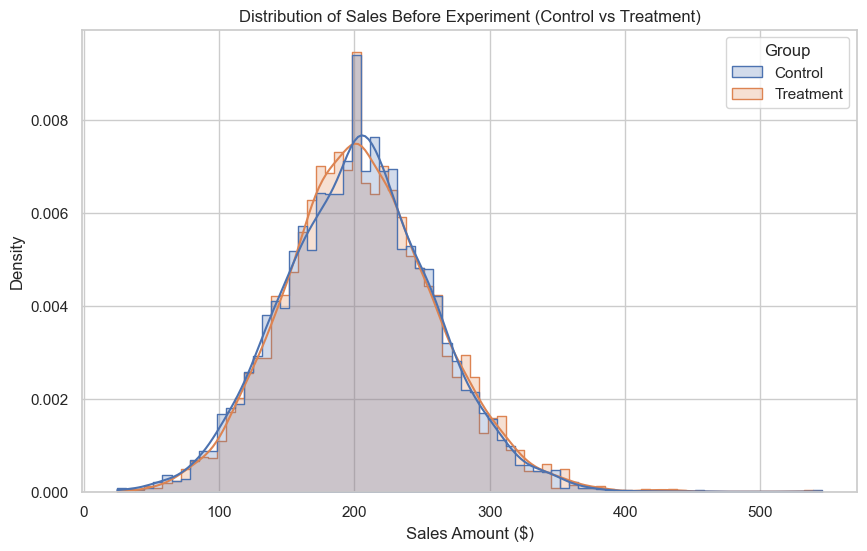

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set(style="whitegrid")

# Create a figure for the distribution of Sales Before
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="Sales_Before", hue="Group", element="step", stat="density", common_norm=False, kde=True)
plt.title("Distribution of Sales Before Experiment (Control vs Treatment)")
plt.xlabel("Sales Amount ($)")
plt.ylabel("Density")

# Save the plot
plt.savefig('sales_before_distribution.png')

Control and Treatment groups are well balanced with no evidence of pre-experiment bias, and the experiment is sufficiently powered to detect economically meaningful effects, ensuring high confidence in subsequent impact estimates.

# Section 3: Revenue Impact Analysis (Sales)

Estimate both raw and causal sales uplift using post-test comparison and Difference-in-Differences analysis.

In [6]:
from scipy import stats

# --- Part 1: Sales Analysis ---

# 1. Simple Post-Test Comparison (Sales_After)
control_sales_after = df[df['Group'] == 'Control']['Sales_After']
treatment_sales_after = df[df['Group'] == 'Treatment']['Sales_After']

t_stat_sales, p_val_sales = stats.ttest_ind(treatment_sales_after, control_sales_after)
lift_sales = (treatment_sales_after.mean() - control_sales_after.mean()) / control_sales_after.mean() * 100

# 2. Difference-in-Differences (DID) - Sales
# Calculate delta for each user
df['Sales_Delta'] = df['Sales_After'] - df['Sales_Before']

control_sales_delta = df[df['Group'] == 'Control']['Sales_Delta']
treatment_sales_delta = df[df['Group'] == 'Treatment']['Sales_Delta']

t_stat_did_sales, p_val_did_sales = stats.ttest_ind(treatment_sales_delta, control_sales_delta)
did_effect_sales = treatment_sales_delta.mean() - control_sales_delta.mean()

# --- Output Results ---
print("--- Sales Analysis ---")
print(f"Avg Sales After (Control): ${control_sales_after.mean():.2f}")
print(f"Avg Sales After (Treatment): ${treatment_sales_after.mean():.2f}")
print(f"Simple Lift: {lift_sales:.2f}%")
print(f"P-value (Sales After): {p_val_sales:.4e}")
print(f"\nDID Estimate (Net Benefit): ${did_effect_sales:.2f}")
print(f"P-value (DID Sales): {p_val_did_sales:.4e}")

--- Sales Analysis ---
Avg Sales After (Control): $242.83
Avg Sales After (Treatment): $318.13
Simple Lift: 31.01%
P-value (Sales After): 0.0000e+00

DID Estimate (Net Benefit): $73.65
P-value (DID Sales): 0.0000e+00


The new store strategy delivers a statistically significant and economically material uplift of **$73.65 per customer**, providing strong causal evidence that the intervention directly drives incremental revenue.

# Section 4: Customer Experience Impact (Satisfaction)

Evaluate whether the sales uplift is accompanied by changes in customer satisfaction using a DID framework.

In [7]:
# --- Part 2: Satisfaction Analysis ---

# 1. Simple Post-Test Comparison (Satisfaction_After)
control_sat_after = df[df['Group'] == 'Control']['Customer_Satisfaction_After']
treatment_sat_after = df[df['Group'] == 'Treatment']['Customer_Satisfaction_After']

t_stat_sat, p_val_sat = stats.ttest_ind(treatment_sat_after, control_sat_after)

# 2. Difference-in-Differences (DID) - Satisfaction
df['Sat_Delta'] = df['Customer_Satisfaction_After'] - df['Customer_Satisfaction_Before']

control_sat_delta = df[df['Group'] == 'Control']['Sat_Delta']
treatment_sat_delta = df[df['Group'] == 'Treatment']['Sat_Delta']

t_stat_did_sat, p_val_did_sat = stats.ttest_ind(treatment_sat_delta, control_sat_delta)
did_effect_sat = treatment_sat_delta.mean() - control_sat_delta.mean()


print("--- Customer Satisfaction Analysis ---")
print(f"Avg Sat After (Control): {control_sat_after.mean():.2f}")
print(f"Avg Sat After (Treatment): {treatment_sat_after.mean():.2f}")
print(f"DID Estimate (Net Impact): {did_effect_sat:.2f} points")
print(f"P-value (DID Sat): {p_val_did_sat:.4e}")

--- Customer Satisfaction Analysis ---
Avg Sat After (Control): 74.15
Avg Sat After (Treatment): 73.69
DID Estimate (Net Impact): 0.01 points
P-value (DID Sat): 9.5787e-01


Customer satisfaction remains statistically unchanged, indicating that revenue gains are achieved without compromising customer experience.

# Section 5: Visual Validation of Experimental Effects

Visualise pre- and post-experiment trends to support statistical findings and assess parallel trends.

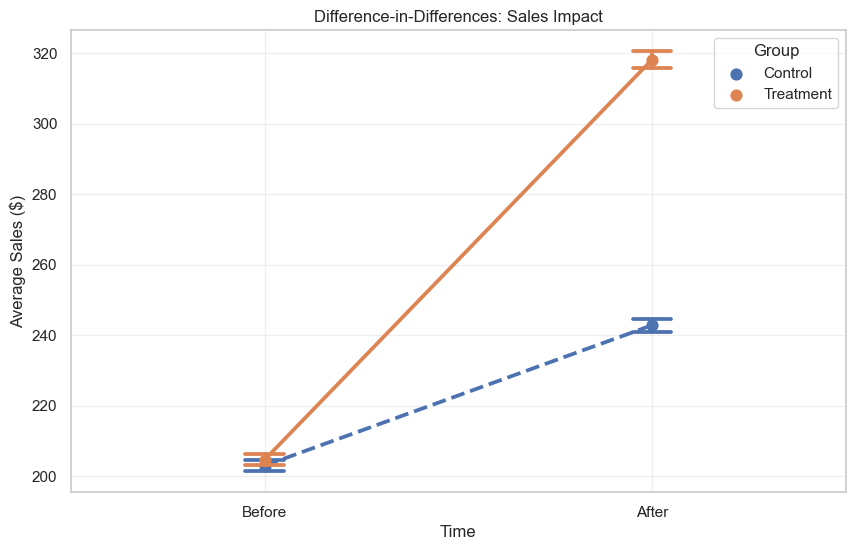

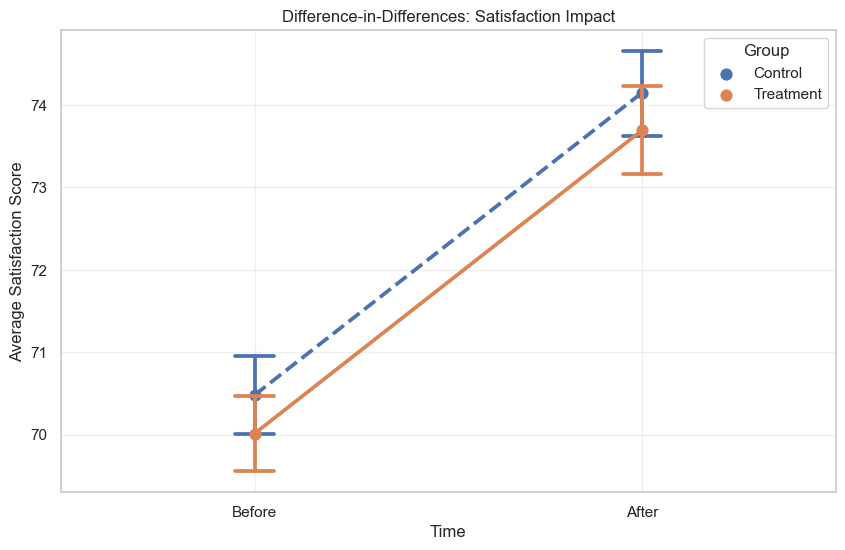

In [8]:
# --- Part 3: Visualization (DID Interaction Plot) ---
# Prepare data for plotting
# Melt the dataframe to have a 'Time' column (Before/After)
plot_data = pd.melt(df, 
                    id_vars=['Group'], 
                    value_vars=['Sales_Before', 'Sales_After'],
                    var_name='Time', 
                    value_name='Sales')

# Rename values for better x-axis labels
plot_data['Time'] = plot_data['Time'].replace({'Sales_Before': 'Before', 'Sales_After': 'After'})

# Calculate means for the plot
mean_data = plot_data.groupby(['Group', 'Time'])['Sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.pointplot(data=plot_data, x='Time', y='Sales', hue='Group', errorbar=('ci', 95), capsize=.1, linestyles=['--', '-'])
plt.title('Difference-in-Differences: Sales Impact')
plt.ylabel('Average Sales ($)')
plt.grid(True, alpha=0.3)
plt.savefig('did_sales_plot.png')

# Satisfaction Plot
plot_data_sat = pd.melt(df, 
                    id_vars=['Group'], 
                    value_vars=['Customer_Satisfaction_Before', 'Customer_Satisfaction_After'],
                    var_name='Time', 
                    value_name='Satisfaction')
plot_data_sat['Time'] = plot_data_sat['Time'].replace({'Customer_Satisfaction_Before': 'Before', 'Customer_Satisfaction_After': 'After'})

plt.figure(figsize=(10, 6))
sns.pointplot(data=plot_data_sat, x='Time', y='Satisfaction', hue='Group', errorbar=('ci', 95), capsize=.1, linestyles=['--', '-'])
plt.title('Difference-in-Differences: Satisfaction Impact')
plt.ylabel('Average Satisfaction Score')
plt.grid(True, alpha=0.3)
plt.savefig('did_sat_plot.png')

Visual evidence confirms a clear post-intervention divergence in sales trends between groups, while satisfaction trends remain parallel, reinforcing the robustness of the causal conclusions.

# Executive Summary
This controlled experiment provides strong causal evidence that the new store strategy drives meaningful revenue uplift without negatively impacting customer satisfaction. The experimental design is statistically robust, well-powered, and suitable for informing rollout decisions.